In [1]:
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.lsimodel import LsiModel
from gensim.corpora import Dictionary

from growing_instability_lib import *

Using TensorFlow backend.


In [2]:
wvmodel = Word2Vec.load('corpus/train_body_data-with_labels_False-retain_special_chars_False.with_test_data.csv.w2v.model')

In [3]:
sample_sub = pd.read_csv('../data/sampleSubmission.csv')
topics = sorted(set(sample_sub.columns.difference(['id'])))

topic2actual = {}
for i in sample_sub.columns:
    if 'id' == i:
        continue
    topic2actual[i] = segment(i)
    
target_columns = sorted(topics)
len(topics)

160

In [4]:
# %%time
# word2idx_trainingX = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'word2idx_trainingX')
_word2idx = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', '_word2idx')
# trainingY = pd.read_hdf('training_data_wv_fs_lsi_no_stopwords.hdf', 'trainingY')

# indices = pd.Index(sorted(trainingY.index[trainingY.index.str.contains('^201[2-4]')]))

# word2idx_trainingX = word2idx_trainingX.ix[indices]
# trainingY = trainingY.ix[indices]

# word2idx_trainingX.to_hdf('training_data_word_index_2012-2014.hdf', 'word2idx_trainingX')
# trainingY.to_hdf('training_data_word_index_2012-2014.hdf', 'trainingY')

word2idx_trainingX = pd.read_hdf('training_data_word_index_2012-2014.hdf', 'word2idx_trainingX')
trainingY = pd.read_hdf('training_data_word_index_2012-2014.hdf', 'trainingY')

In [5]:
train_test_df = pd.read_hdf('train_test_df_3.hdf', 'train_test_df')

In [6]:
def transform_topics(df, topics):
    topics = sorted(topics)
#     v = np.zeros(shape=(df.shape[0], len(topics)))
    v = []
    for ix, tp in enumerate(df.topics):
        tt = []
        for t in tp:
            tt.append(topics.index(t))
#             v[ix][topics.index(t)] = 1
        v.append(tt)

    return pd.Series(v, index=df.index)

In [7]:
ind2word = {j:i for i, j in _word2idx.iteritems()}
ind2class = dict(enumerate(topics))
class2ind = {j: i for i, j in ind2class.items()}

In [8]:
def process_vector(term_vecs, vector_size, mean_window=5, sequence_length=200):
    # 85 percentile length of docs is (198 * 5)

    q = np.arange(0, len(term_vecs), mean_window)
    
    sequence = np.zeros([1, sequence_length, vector_size])
    
    for ix, inds in  enumerate(zip(q, q + mean_window)):
        if ix < sequence_length:
            sequence[0][ix] = np.mean(term_vecs[inds[0]: inds[1]], axis=0)
        else:
            break

    return sequence


def process_ind2word(term_idx):
    return [ind2word.get(idx, -1) for idx in term_idx]

In [9]:
word2idx_trainingX.map(len).quantile(0.8) / 5

197.4

In [10]:
def transform_mean_average(term_idx, stopwords=[], stack=True):
    ret = term_idx.map(process_ind2word).map(
        lambda x: [wvmodel[i] for i in x if i in wvmodel.wv.vocab]
    ).map(
        lambda x: process_vector(x, wvmodel.vector_size)
    )
    
    if stack:
        ret = np.vstack(ret)
        
    return ret


def parallel_generate_word_vectors(samp, transformer, stopwords, batch, num_proc):
    with Parallel(n_jobs=num_proc) as parallel:
        dataset = np.zeros([samp.shape[0], 200, 300])
        is_break = False
        i = 0

        while not is_break:
            payload = []

            for j in xrange(num_proc):
                t_df = samp[(i + j) * batch: (i + 1 + j) * batch]

                if t_df.empty:
                    is_break = True
                    continue

                payload.append(
                    delayed(transformer)(
                        t_df, stopwords
                    )
                )

            print('Current batch in main thread: {}'.format((i + j) * batch))

            if payload:
                results = parallel(payload)
                dataset.extend(results)
                i += num_proc

    return np.vstack(dataset)

In [11]:
train_test_word_indices = transform_text(train_test_df).map(lambda x: [_word2idx.get(i) for i in x.split()])

In [12]:
%%time
x_train = np.zeros(
    [word2idx_trainingX.shape[0] + train_test_word_indices.shape[0], 200, 300], dtype=np.float32
)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 26.9 µs


In [13]:
%%time
i = 0

for ix, chunk in enumerate(np.array_split(pd.concat([word2idx_trainingX, train_test_word_indices]), 25)):
    chunk = transform_mean_average(chunk)
    j = i + chunk.shape[0]
    x_train[i: j] = chunk
    print ix, i, j

    i = j    

0 0 2280
1 2280 4560
2 4560 6840
3 6840 9120
4 9120 11400
5 11400 13680
6 13680 15960
7 15960 18240
8 18240 20520
9 20520 22800
10 22800 25080
11 25080 27360
12 27360 29640
13 29640 31920
14 31920 34200
15 34200 36480
16 36480 38760
17 38760 41040
18 41040 43320
19 43320 45600
20 45600 47880
21 47880 50160
22 50160 52440
23 52440 54720
24 54720 56999
CPU times: user 2min 28s, sys: 9.46 s, total: 2min 38s
Wall time: 2min 32s


In [14]:
200 * 60000 * 300 * 8. / 1000000000

28.8

In [15]:
def build_target(y, size):
    e = np.zeros(size)
    e[y] = 1
    return e

In [16]:
# %%time
# # 6853
# # 3110
# x_dump = parallel_generate_word_vectors(
#     pd.concat([word2idx_trainingX, train_test_word_indices]),
#     transform_mean_average,
#     stopwords=[],
#     batch=1000,
#     num_proc=5
# )

In [17]:
%%time
num_samples = x_train.shape[0]

training_Y = pd.DataFrame(zip(*np.where(trainingY.head(num_samples) == 1)), columns=['iloc', 'topics'])
training_Y = training_Y.groupby('iloc')['topics'].apply(list)
training_Y.index = trainingY.head(num_samples).index

train_test_y = transform_topics(train_test_df, topics)
y_train = pd.concat([training_Y, train_test_y])
y_train = np.vstack(y_train.map(lambda x: build_target(x, len(topics))))

CPU times: user 2.26 s, sys: 28 ms, total: 2.29 s
Wall time: 2.24 s


In [18]:
y_train.shape, x_train.shape

((56999, 160), (56999, 200, 300))

In [19]:
import tensorflow as K
import keras.backend as KB


def f1_micro(y_true, y_pred):
    TP = K.metrics.true_positives(y_true, K.round(y_pred))
    FP = K.metrics.false_positives(y_true, K.round(y_pred))
    FN = K.metrics.false_negatives(y_true, K.round(y_pred))
    
    p = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FP))
    r = K.reduce_sum(TP) / (K.reduce_sum(TP) + K.reduce_sum(FN))
    
    return (2.0 * p * r) / (p + r)


def f1_score(y_true, y_pred):
    # http://stackoverflow.com/questions/43345909/when-using-mectrics-in-model-compile-in-keras-report-valueerror-unknown-metr
    # Count positive samples.
    c1 = KB.sum(KB.round(KB.clip(y_true * y_pred, 0, 1)))
    c2 = KB.sum(KB.round(KB.clip(y_pred, 0, 1)))
    c3 = KB.sum(KB.round(KB.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

In [59]:
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Convolution1D, MaxPooling1D, Flatten, TimeDistributed
from keras.models import Model
import itertools as it


fma_input = Input(shape=(None, 300), name='fma_input')
bma_input = Input(shape=(None, 300), name='bma_input')

fma_x = LSTM(32, return_sequences=False)(fma_input)
bma_x = LSTM(32, return_sequences=False, go_backwards=True)(bma_input)
# We stack a deep densely-connected network on top

merge_layer = keras.layers.concatenate([fma_x, bma_x])

# x = TimeDistributed(Dense(128, activation='relu'))(merge_layer)
x = Dense(128, activation='relu')(merge_layer)
x = Dropout(0.1)(x)

# And finally we add the main logistic regression layer
main_output = Dense(len(class2ind), activation='sigmoid', name='main_output')(x)

model = Model(
    inputs=[
        fma_input,
        bma_input
    ],
    outputs=[main_output]
)

In [60]:
optimizer = keras.optimizers.RMSprop(lr=0.003)
model.compile(
    optimizer=optimizer,  # keras.optimizers.RMSprop(lr=0.005),  # , rho=0.9, epsilon=1e-08, decay=0.0, clipnorm=1),
    loss={'main_output': 'categorical_crossentropy'},
    loss_weights={'main_output': 1.},
    metrics=['accuracy', f1_micro]
)

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
fma_input (InputLayer)           (None, None, 300)     0                                            
____________________________________________________________________________________________________
bma_input (InputLayer)           (None, None, 300)     0                                            
____________________________________________________________________________________________________
lstm_19 (LSTM)                   (None, 32)            42624                                        
____________________________________________________________________________________________________
lstm_20 (LSTM)                   (None, 32)            42624                                        
___________________________________________________________________________________________

In [52]:
y_train.shape

(56999, 160)

In [54]:
def generate_batch_train_data(x, y, batch_size=1000, shuffle=True):
    s = x.shape[0]
    q = np.arange(0, s, batch_size)
    indices = zip(q, q + batch_size)
    while True:
        if shuffle:
            np.random.shuffle(indices)
        for i, j in indices:
            _y = y[i: j]
            _x = x[i: j]
            if _y.shape[0] > 0:
#                 print('hello')
                yield (np.vstack(_x), _y)

In [53]:
batch_size = 2000
epochs = 10
# steps_per_epoch = (x_dump.shape[0] + batch_size) / batch_size

# train_data_generator = generate_batch_train_data(x_dump, y_train, batch_size=batch_size, shuffle=True)

In [54]:
# %%time
# model.fit_generator(
#     train_data_generator,
#     steps_per_epoch=steps_per_epoch,
#     epochs=epochs,
#     workers=1,
# )

In [55]:
base_file_name = "actual-bidirectional-lstm-weights"
filepath = base_file_name + ".{epoch:02d}-{loss:.4f}-{acc:.4f}-{f1_micro:.4f}.hdf5"
filename = base_file_name + ".log"

model_check_point = keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    monitor='f1_micro', verbose=0,
    save_best_only=True, save_weights_only=False,
    mode='max', period=1,
)

remote_monitor = keras.callbacks.RemoteMonitor(
    root='http://localhost:9000',
    path='/publish/epoch/end/',
    field='data', headers=None
)

csv_logger = keras.callbacks.CSVLogger(filename=filename, separator=',', append=False)

callbacks = [model_check_point, remote_monitor, csv_logger]

In [61]:
# %%time
batch_size = 2000
epochs = 10
hist = model.fit(
    [x_train, x_train],
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/10
56999/56999 [==============================] - 32s - loss: 6.4130 - acc: 0.0748 - f1_micro: 0.0636    
Epoch 2/10
56999/56999 [==============================] - 32s - loss: 5.5858 - acc: 0.1288 - f1_micro: 0.0915    
Epoch 3/10
56999/56999 [==============================] - 31s - loss: 4.9795 - acc: 0.1935 - f1_micro: 0.1075    
Epoch 4/10
56999/56999 [==============================] - 31s - loss: 4.5148 - acc: 0.2622 - f1_micro: 0.1158    
Epoch 5/10
56999/56999 [==============================] - 31s - loss: 4.1135 - acc: 0.3273 - f1_micro: 0.1203    
Epoch 6/10
56999/56999 [==============================] - 31s - loss: 3.7717 - acc: 0.3886 - f1_micro: 0.1232    
Epoch 7/10
56999/56999 [==============================] - 31s - loss: 3.4776 - acc: 0.4406 - f1_micro: 0.1257    
Epoch 8/10
56999/56999 [==============================] - 31s - loss: 3.2444 - acc: 0.4815 - f1_micro: 0.1292    
Epoch 9/10
56999/56999 [==============================] - 32s - loss: 3.0688 - acc: 0.50

In [62]:
# %%time
batch_size = 2000
epochs = 10
hist = model.fit(
    [x_train, x_train],
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/10
56999/56999 [==============================] - 24s - loss: 2.8313 - acc: 0.5465 - f1_micro: 0.1462    
Epoch 2/10
56999/56999 [==============================] - 24s - loss: 2.7784 - acc: 0.5526 - f1_micro: 0.1524    
Epoch 3/10
56999/56999 [==============================] - 24s - loss: 2.7184 - acc: 0.5621 - f1_micro: 0.1590    
Epoch 4/10
56999/56999 [==============================] - 24s - loss: 2.6853 - acc: 0.5647 - f1_micro: 0.1656    
Epoch 5/10
56999/56999 [==============================] - 24s - loss: 2.6365 - acc: 0.5739 - f1_micro: 0.1726    
Epoch 6/10
56999/56999 [==============================] - 24s - loss: 2.5846 - acc: 0.5822 - f1_micro: 0.1796    
Epoch 7/10
56999/56999 [==============================] - 24s - loss: 2.5587 - acc: 0.5843 - f1_micro: 0.1866    
Epoch 8/10
56999/56999 [==============================] - 24s - loss: 2.5226 - acc: 0.5885 - f1_micro: 0.1938    
Epoch 9/10
56999/56999 [==============================] - 24s - loss: 2.4886 - acc: 0.59

In [63]:
# %%time
batch_size = 2000
epochs = 50
hist = model.fit(
    [x_train, x_train],
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/50
56999/56999 [==============================] - 24s - loss: 2.4305 - acc: 0.6010 - f1_micro: 0.2150    
Epoch 2/50
56999/56999 [==============================] - 24s - loss: 2.4084 - acc: 0.6044 - f1_micro: 0.2220    
Epoch 3/50
56999/56999 [==============================] - 24s - loss: 2.3710 - acc: 0.6076 - f1_micro: 0.2289    
Epoch 4/50
56999/56999 [==============================] - 24s - loss: 2.3591 - acc: 0.6093 - f1_micro: 0.2356    
Epoch 5/50
56999/56999 [==============================] - 24s - loss: 2.3307 - acc: 0.6148 - f1_micro: 0.2423    
Epoch 6/50
56999/56999 [==============================] - 24s - loss: 2.3068 - acc: 0.6165 - f1_micro: 0.2487    
Epoch 7/50
56999/56999 [==============================] - 24s - loss: 2.2888 - acc: 0.6185 - f1_micro: 0.2552    
Epoch 8/50
56999/56999 [==============================] - 24s - loss: 2.2671 - acc: 0.6204 - f1_micro: 0.2615    
Epoch 9/50
56999/56999 [==============================] - 24s - loss: 2.2459 - acc: 0.62

In [64]:
# %%time
batch_size = 2500
epochs = 50
hist = model.fit(
    [x_train, x_train],
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/50
56999/56999 [==============================] - 23s - loss: 1.7898 - acc: 0.6784 - f1_micro: 0.4354    
Epoch 2/50
56999/56999 [==============================] - 23s - loss: 1.7916 - acc: 0.6782 - f1_micro: 0.4379    
Epoch 3/50
56999/56999 [==============================] - 23s - loss: 1.7758 - acc: 0.6799 - f1_micro: 0.4404    
Epoch 4/50
56999/56999 [==============================] - 23s - loss: 1.7792 - acc: 0.6803 - f1_micro: 0.4428    
Epoch 5/50
56999/56999 [==============================] - 23s - loss: 1.7691 - acc: 0.6820 - f1_micro: 0.4452    
Epoch 6/50
56999/56999 [==============================] - 23s - loss: 1.7668 - acc: 0.6799 - f1_micro: 0.4476    
Epoch 7/50
56999/56999 [==============================] - 23s - loss: 1.7595 - acc: 0.6823 - f1_micro: 0.4499    
Epoch 8/50
56999/56999 [==============================] - 23s - loss: 1.7527 - acc: 0.6835 - f1_micro: 0.4522    
Epoch 9/50
56999/56999 [==============================] - 23s - loss: 1.7532 - acc: 0.68

In [66]:
# %%time
batch_size = 2000
epochs = 50
hist = model.fit(
    [x_train, x_train],
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/50
56999/56999 [==============================] - 24s - loss: 1.5817 - acc: 0.7032 - f1_micro: 0.5256    
Epoch 2/50
56999/56999 [==============================] - 24s - loss: 1.5705 - acc: 0.7061 - f1_micro: 0.5268    
Epoch 3/50
56999/56999 [==============================] - 24s - loss: 1.5694 - acc: 0.7058 - f1_micro: 0.5280    
Epoch 4/50
56999/56999 [==============================] - 24s - loss: 1.5663 - acc: 0.7067 - f1_micro: 0.5292    
Epoch 5/50
56999/56999 [==============================] - 24s - loss: 1.5642 - acc: 0.7071 - f1_micro: 0.5304    
Epoch 6/50
56999/56999 [==============================] - 24s - loss: 1.5607 - acc: 0.7105 - f1_micro: 0.5316    
Epoch 7/50
56999/56999 [==============================] - 24s - loss: 1.5590 - acc: 0.7081 - f1_micro: 0.5328    
Epoch 8/50
56999/56999 [==============================] - 24s - loss: 1.5576 - acc: 0.7091 - f1_micro: 0.5339    
Epoch 9/50
56999/56999 [==============================] - 24s - loss: 1.5505 - acc: 0.70

In [67]:
%%time
batch_size = 2000
epochs = 50
hist = model.fit(
    [x_train, x_train],
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/50
56999/56999 [==============================] - 24s - loss: 1.4266 - acc: 0.7215 - f1_micro: 0.5755    
Epoch 2/50
56999/56999 [==============================] - 24s - loss: 1.4278 - acc: 0.7235 - f1_micro: 0.5763    
Epoch 3/50
56999/56999 [==============================] - 24s - loss: 1.4270 - acc: 0.7235 - f1_micro: 0.5772    
Epoch 4/50
56999/56999 [==============================] - 24s - loss: 1.4191 - acc: 0.7268 - f1_micro: 0.5780    
Epoch 5/50
56999/56999 [==============================] - 24s - loss: 1.4164 - acc: 0.7259 - f1_micro: 0.5788    
Epoch 6/50
56999/56999 [==============================] - 24s - loss: 1.4233 - acc: 0.7232 - f1_micro: 0.5796    
Epoch 7/50
56999/56999 [==============================] - 24s - loss: 1.4140 - acc: 0.7255 - f1_micro: 0.5804    
Epoch 8/50
56999/56999 [==============================] - 24s - loss: 1.4124 - acc: 0.7253 - f1_micro: 0.5812    
Epoch 9/50
56999/56999 [==============================] - 24s - loss: 1.4129 - acc: 0.72

In [84]:
%%time
batch_size = 2000
epochs = 50
hist = model.fit(
    [x_train, x_train],
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/50
56999/56999 [==============================] - 24s - loss: 1.3363 - acc: 0.7342 - f1_micro: 0.6111    
Epoch 2/50
56999/56999 [==============================] - 24s - loss: 1.3243 - acc: 0.7360 - f1_micro: 0.6117    
Epoch 3/50
56999/56999 [==============================] - 24s - loss: 1.3341 - acc: 0.7337 - f1_micro: 0.6123    
Epoch 4/50
56999/56999 [==============================] - 24s - loss: 1.3248 - acc: 0.7349 - f1_micro: 0.6129    
Epoch 5/50
56999/56999 [==============================] - 24s - loss: 1.3244 - acc: 0.7352 - f1_micro: 0.6135    
Epoch 6/50
56999/56999 [==============================] - 24s - loss: 1.3218 - acc: 0.7378 - f1_micro: 0.6142    
Epoch 7/50
56999/56999 [==============================] - 24s - loss: 1.3262 - acc: 0.7358 - f1_micro: 0.6148    
Epoch 8/50
56999/56999 [==============================] - 24s - loss: 1.3198 - acc: 0.7376 - f1_micro: 0.6154    
Epoch 9/50
56999/56999 [==============================] - 24s - loss: 1.3202 - acc: 0.73

In [70]:
from sklearn.metrics import f1_score as sk_f1_score


In [85]:
g = model.predict(
    [x_train, x_train],
    batch_size=batch_size
)

In [87]:
%%time
dt = 0.01
s = 0.0
e = 0.6
th = np.arange(s, e + dt, dt)
mean_fscores = []
for t in th:
    # %time 
    mean_fscores.append((t, sk_f1_score(y_train, 1.0 * (g > t), average='micro')))
    print t, mean_fscores[-1]

0.0 (0.0, 0.020880745251391636)
0.01 (0.01, 0.6726014644899474)
0.02 (0.02, 0.72101077588096552)
0.03 (0.029999999999999999, 0.74744159104074137)
0.04 (0.040000000000000001, 0.76474864236947504)
0.05 (0.050000000000000003, 0.77706702263968941)
0.06 (0.059999999999999998, 0.78639995230145476)
0.07 (0.070000000000000007, 0.79346799408018032)
0.08 (0.080000000000000002, 0.79917763832492528)
0.09 (0.089999999999999997, 0.80371706683971444)
0.1 (0.10000000000000001, 0.80712421698197423)
0.11 (0.11, 0.80978243574375997)
0.12 (0.12, 0.81227444555102213)
0.13 (0.13, 0.81385917257542784)
0.14 (0.14000000000000001, 0.81558336873522652)
0.15 (0.14999999999999999, 0.81655641863146056)
0.16 (0.16, 0.81742265874727638)
0.17 (0.17000000000000001, 0.8181007976471637)
0.18 (0.17999999999999999, 0.81834903544190218)
0.19 (0.19, 0.81845056755353951)
0.2 (0.20000000000000001, 0.81850533807829184)
0.21 (0.20999999999999999, 0.8180380198607804)
0.22 (0.22, 0.81798080623022185)
0.23 (0.23000000000000001, 0.8

In [88]:
thresh, thresh_score = sorted(mean_fscores, key=lambda x: x[1], reverse=True)[0]
thresh, thresh_score

(0.20000000000000001, 0.81850533807829184)

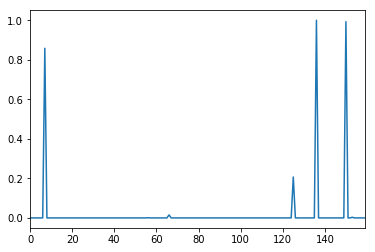

In [91]:
%matplotlib inline
ix = 13
sd = -0
pd.Series(g[sd:][ix]).plot()

In [92]:
# thresh = 0.5
np.where(y_train[sd:][ix] == 1), np.where(g[sd:][ix] > thresh)

((array([  7, 136, 150]),), (array([  7, 125, 136, 150]),))

In [95]:
topics[150]

'unitednations'

In [75]:
def get_classes(pred, scale_param=0.75, min_thresh=0.05, thresh = 0.5):
#     mx = pred.mean() + 3 * pred.std()
    return np.where(pred > thresh)[0]  

In [76]:
with open('../data/TestData.json') as fl:
    data = json.load(fl)
    test_df = pd.DataFrame(data['TestData']).T
    del(data)

In [77]:
%%time
test_word_indices = transform_text(test_df).map(lambda x: [_word2idx.get(i) for i in x.split()])

CPU times: user 37.1 s, sys: 204 ms, total: 37.3 s
Wall time: 36.8 s


In [78]:
# test_null_index = test_word_indices[test_word_indices.map(len) == 0].index

In [79]:
%%time
x_test = np.zeros(
    [test_word_indices.shape[0], 200, 300], dtype=np.float32
)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 41 µs


In [80]:
%%time
ii = 0

for ix, chunk in enumerate(np.array_split(test_word_indices, 10)):
    chunk = transform_mean_average(chunk)
    jj = ii + chunk.shape[0]
    x_test[ii: jj] = chunk
    print ix, ii, jj

    ii = jj

0 0 759
1 759 1517
2 1517 2275
3 2275 3033
4 3033 3791
5 3791 4549
6 4549 5307
7 5307 6065
8 6065 6823
9 6823 7581
CPU times: user 23.9 s, sys: 1.79 s, total: 25.7 s
Wall time: 23.5 s


In [96]:
test_probas = model.predict([x_test, x_test], batch_size=batch_size)

In [108]:
# %%time
# valid_test_feature_vec found below!
thresh = 0.3
# pos_count = []
# dt = 0.01
# for thresh in  np.arange(0, 0.5 + dt, dt):
test_values = np.zeros([test_probas.shape[0], len(topics)])
for ix, pred in enumerate(test_probas):
    for v in get_classes(pred, thresh=thresh):
        test_values[ix][v] = 1

test_sub_df = pd.DataFrame(
    test_values,
    index=test_df.index,
    columns=topics
)

test_sub_df = test_sub_df.sort_index()
a = test_sub_df.sum(axis=0).sum()
#     pos_count.append((thresh, a))
print a

12762.0


In [110]:
# pos_count = pd.DataFrame(pos_count, columns=['thresh', 'counts'])

In [111]:
a

12762.0

In [112]:
hist.history['loss'][-1]

1.2696791664818157

In [114]:
sub_filename = 'actual-bidirectional-lstm-mean_averaged_window-loss_{:.4f}-f1_micro_{:.4f}-thresh_{}.csv'.format(hist.history['loss'][-1], hist.history['f1_micro'][-1], thresh)
print sub_filename

actual-bidirectional-lstm-mean_averaged_window-loss_1.2697-f1_micro_0.6380-thresh_0.3.csv


In [115]:
test_sub_df.astype(int).reset_index().rename(
    columns={'index': 'id'}
).sort_values('id').to_csv(
    sub_filename, 
    index=False
)

In [268]:
test_sub_df.sum().describe()

count     160.00000
mean       69.68125
std       154.89779
min         0.00000
25%         4.00000
50%        16.50000
75%        59.25000
max      1390.00000
dtype: float64

In [229]:
test_sub_df.sum()

activism                                    0.0
afghanistan                               173.0
aid                                        89.0
algerianhostagecrisis                      19.0
alqaida                                   177.0
alshabaab                                  40.0
antiwar                                     0.0
arabandmiddleeastprotests                 434.0
armstrade                                 107.0
australianguncontrol                        0.0
australiansecurityandcounterterrorism      42.0
bastilledaytruckattack                     15.0
belgium                                    24.0
berlinchristmasmarketattack                10.0
bigdata                                     1.0
biometrics                                  0.0
bokoharam                                  41.0
bostonmarathonbombing                      52.0
britisharmy                                15.0
brusselsattacks                            34.0
cameroon                                

In [284]:
test_sub_df.sum()

activism                                    0.0
afghanistan                               147.0
aid                                       127.0
algerianhostagecrisis                      34.0
alqaida                                   246.0
alshabaab                                  46.0
antiwar                                     0.0
arabandmiddleeastprotests                 376.0
armstrade                                  78.0
australianguncontrol                        0.0
australiansecurityandcounterterrorism      64.0
bastilledaytruckattack                      9.0
belgium                                    12.0
berlinchristmasmarketattack                12.0
bigdata                                     3.0
biometrics                                  0.0
bokoharam                                  65.0
bostonmarathonbombing                      77.0
britisharmy                                12.0
brusselsattacks                            41.0
cameroon                                

In [83]:
test_sub_df.sum()

activism                                    0.0
afghanistan                               129.0
aid                                        87.0
algerianhostagecrisis                      22.0
alqaida                                   224.0
alshabaab                                  29.0
antiwar                                     1.0
arabandmiddleeastprotests                 429.0
armstrade                                  67.0
australianguncontrol                        0.0
australiansecurityandcounterterrorism      84.0
bastilledaytruckattack                     19.0
belgium                                    53.0
berlinchristmasmarketattack                15.0
bigdata                                     7.0
biometrics                                  1.0
bokoharam                                  40.0
bostonmarathonbombing                      79.0
britisharmy                                16.0
brusselsattacks                           108.0
cameroon                                

In [107]:
test_sub_df.sum()

activism                                    0.0
afghanistan                               117.0
aid                                        57.0
algerianhostagecrisis                       8.0
alqaida                                   168.0
alshabaab                                  36.0
antiwar                                     0.0
arabandmiddleeastprotests                 166.0
armstrade                                  42.0
australianguncontrol                        0.0
australiansecurityandcounterterrorism      51.0
bastilledaytruckattack                     22.0
belgium                                    24.0
berlinchristmasmarketattack                13.0
bigdata                                     3.0
biometrics                                  1.0
bokoharam                                  35.0
bostonmarathonbombing                      68.0
britisharmy                                 2.0
brusselsattacks                            63.0
cameroon                                